### Below used for debugging individual circuit runs


In [1]:
from qiskit import transpile
from qiskit.circuit.library import CZGate, iSwapGate
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(2)
qc.cz(0, 1)
qc.swap(0, 1)

qc2 = QuantumCircuit(2)
qc2.rz(-np.pi / 2, 0)
qc2.rz(-np.pi / 2, 1)
qc2.iswap(0, 1)


Operator(qc).equiv(qc2)

True

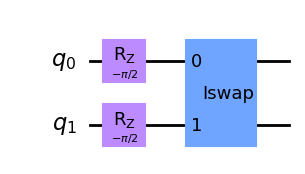

In [2]:
qc2.draw("mpl")

In [3]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from transpile_benchy.metrics.timer import TimeMetric
from mirror_gates.fast_unitary import FastConsolidateBlocks
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    Unroll3qOrMore,
    ConsolidateBlocks,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger

In [4]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qft_n4 from QASMBench


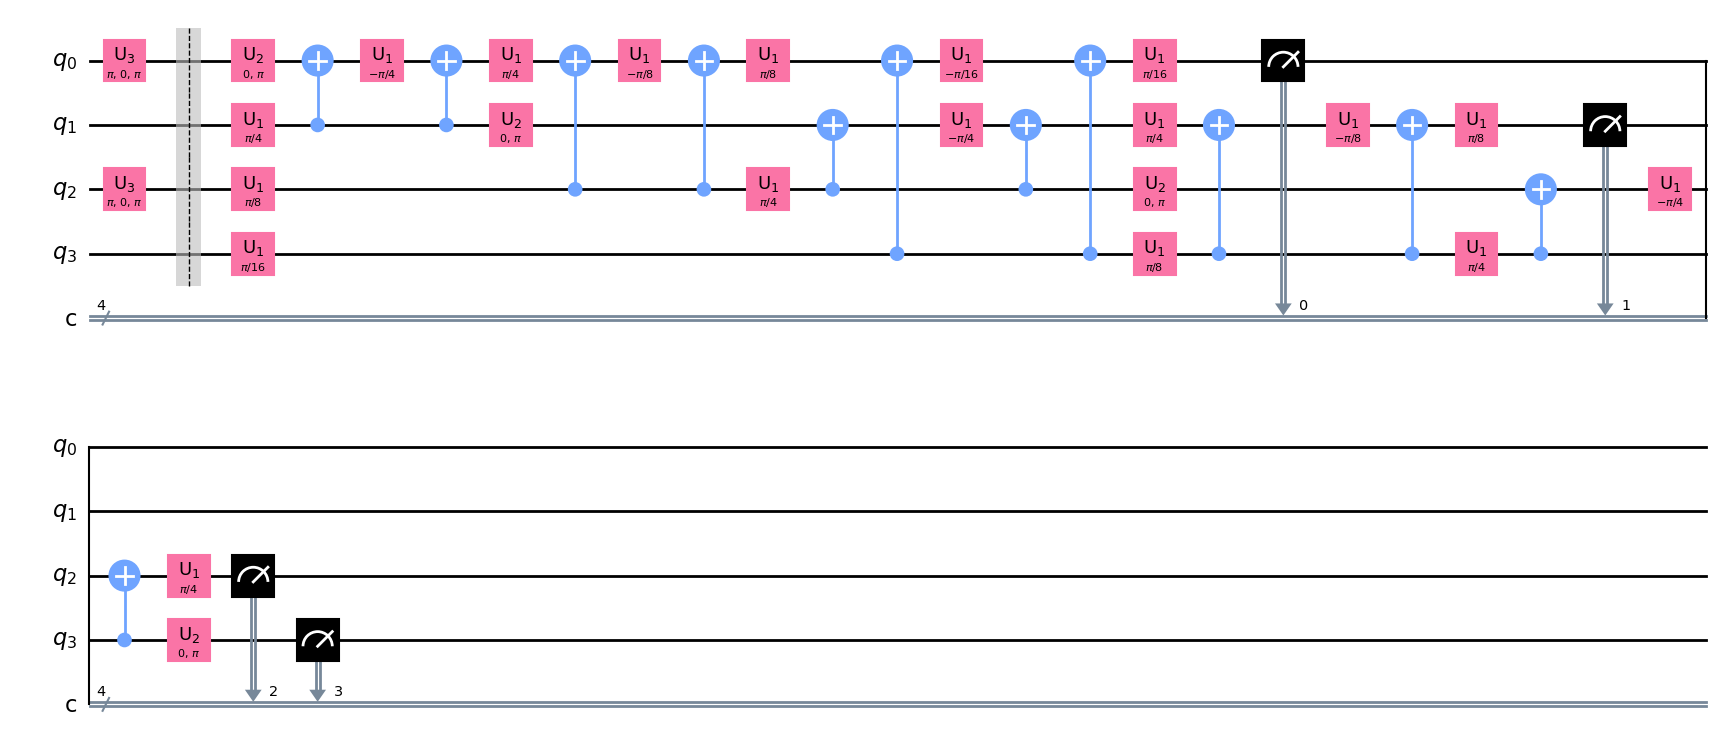

In [5]:
from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_txt("../circuits/debug.txt")
qc = lib.get_circuit("qft_n4")
qc = qc.decompose()
display(qc.draw("mpl"))

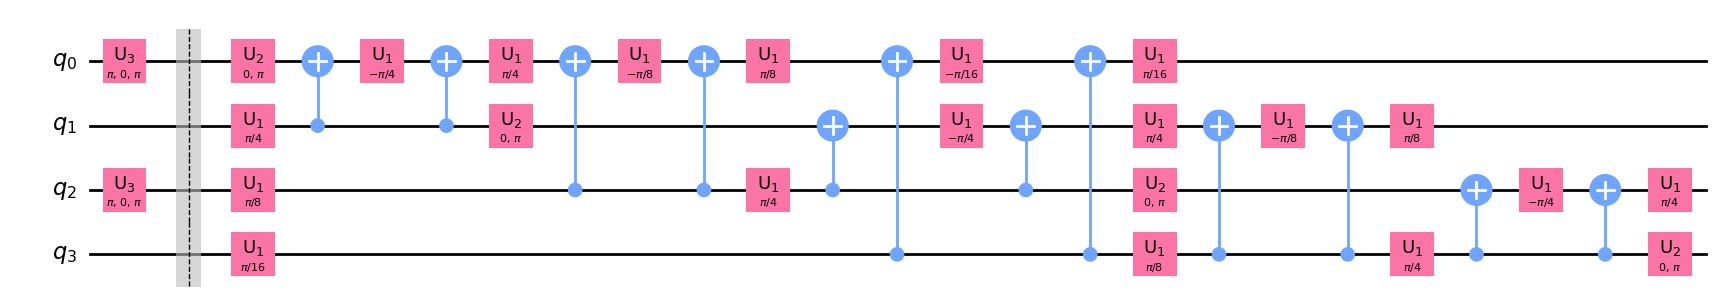

In [6]:
qc.remove_final_measurements()
qc.draw("mpl")

In [7]:
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator

perfect_result = AerSimulator().run(qc).result().data()["density_matrix"]
# noisy_result = NoisySimulator().run(qc).result().data()["density_matrix"]
# state_fidelity(perfect_result, noisy_result)

KeyError: 'density_matrix'

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx
6.5
8.0
0


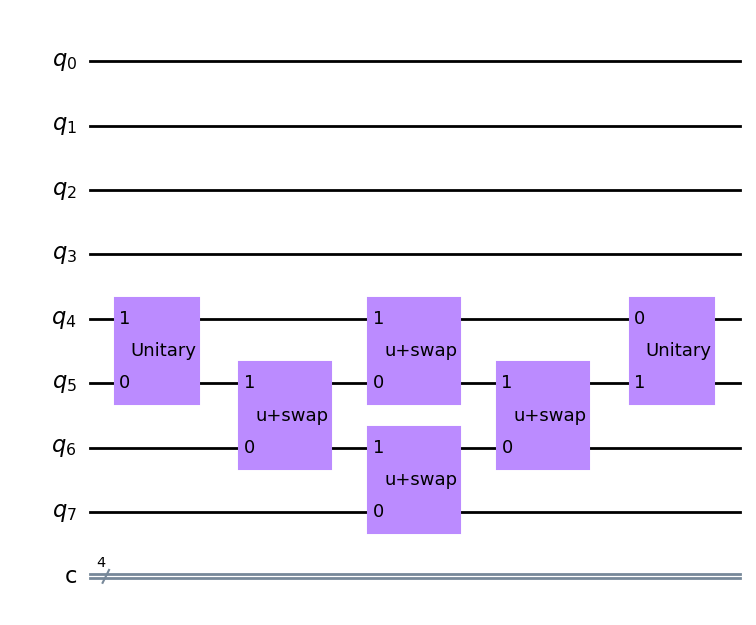

In [4]:
runner = Mirage(
    coupling_map,
    cx_basis=0,
    # parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=5,
    fb_iters=16,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
)

runner.seed = 0
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
# metric = TimeMetric()
# runner._append_metric_pass(metric)

transp = runner.run(qc)
# print(runner.property_set["accepted_subs"])
print(runner.property_set["monodromy_depth"])
print(runner.property_set["monodromy_total"])
print(runner.property_set["total_swaps"])
display(runner.property_set["mid"].draw("mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))
# display(transp.draw(output="mpl", fold=-1))

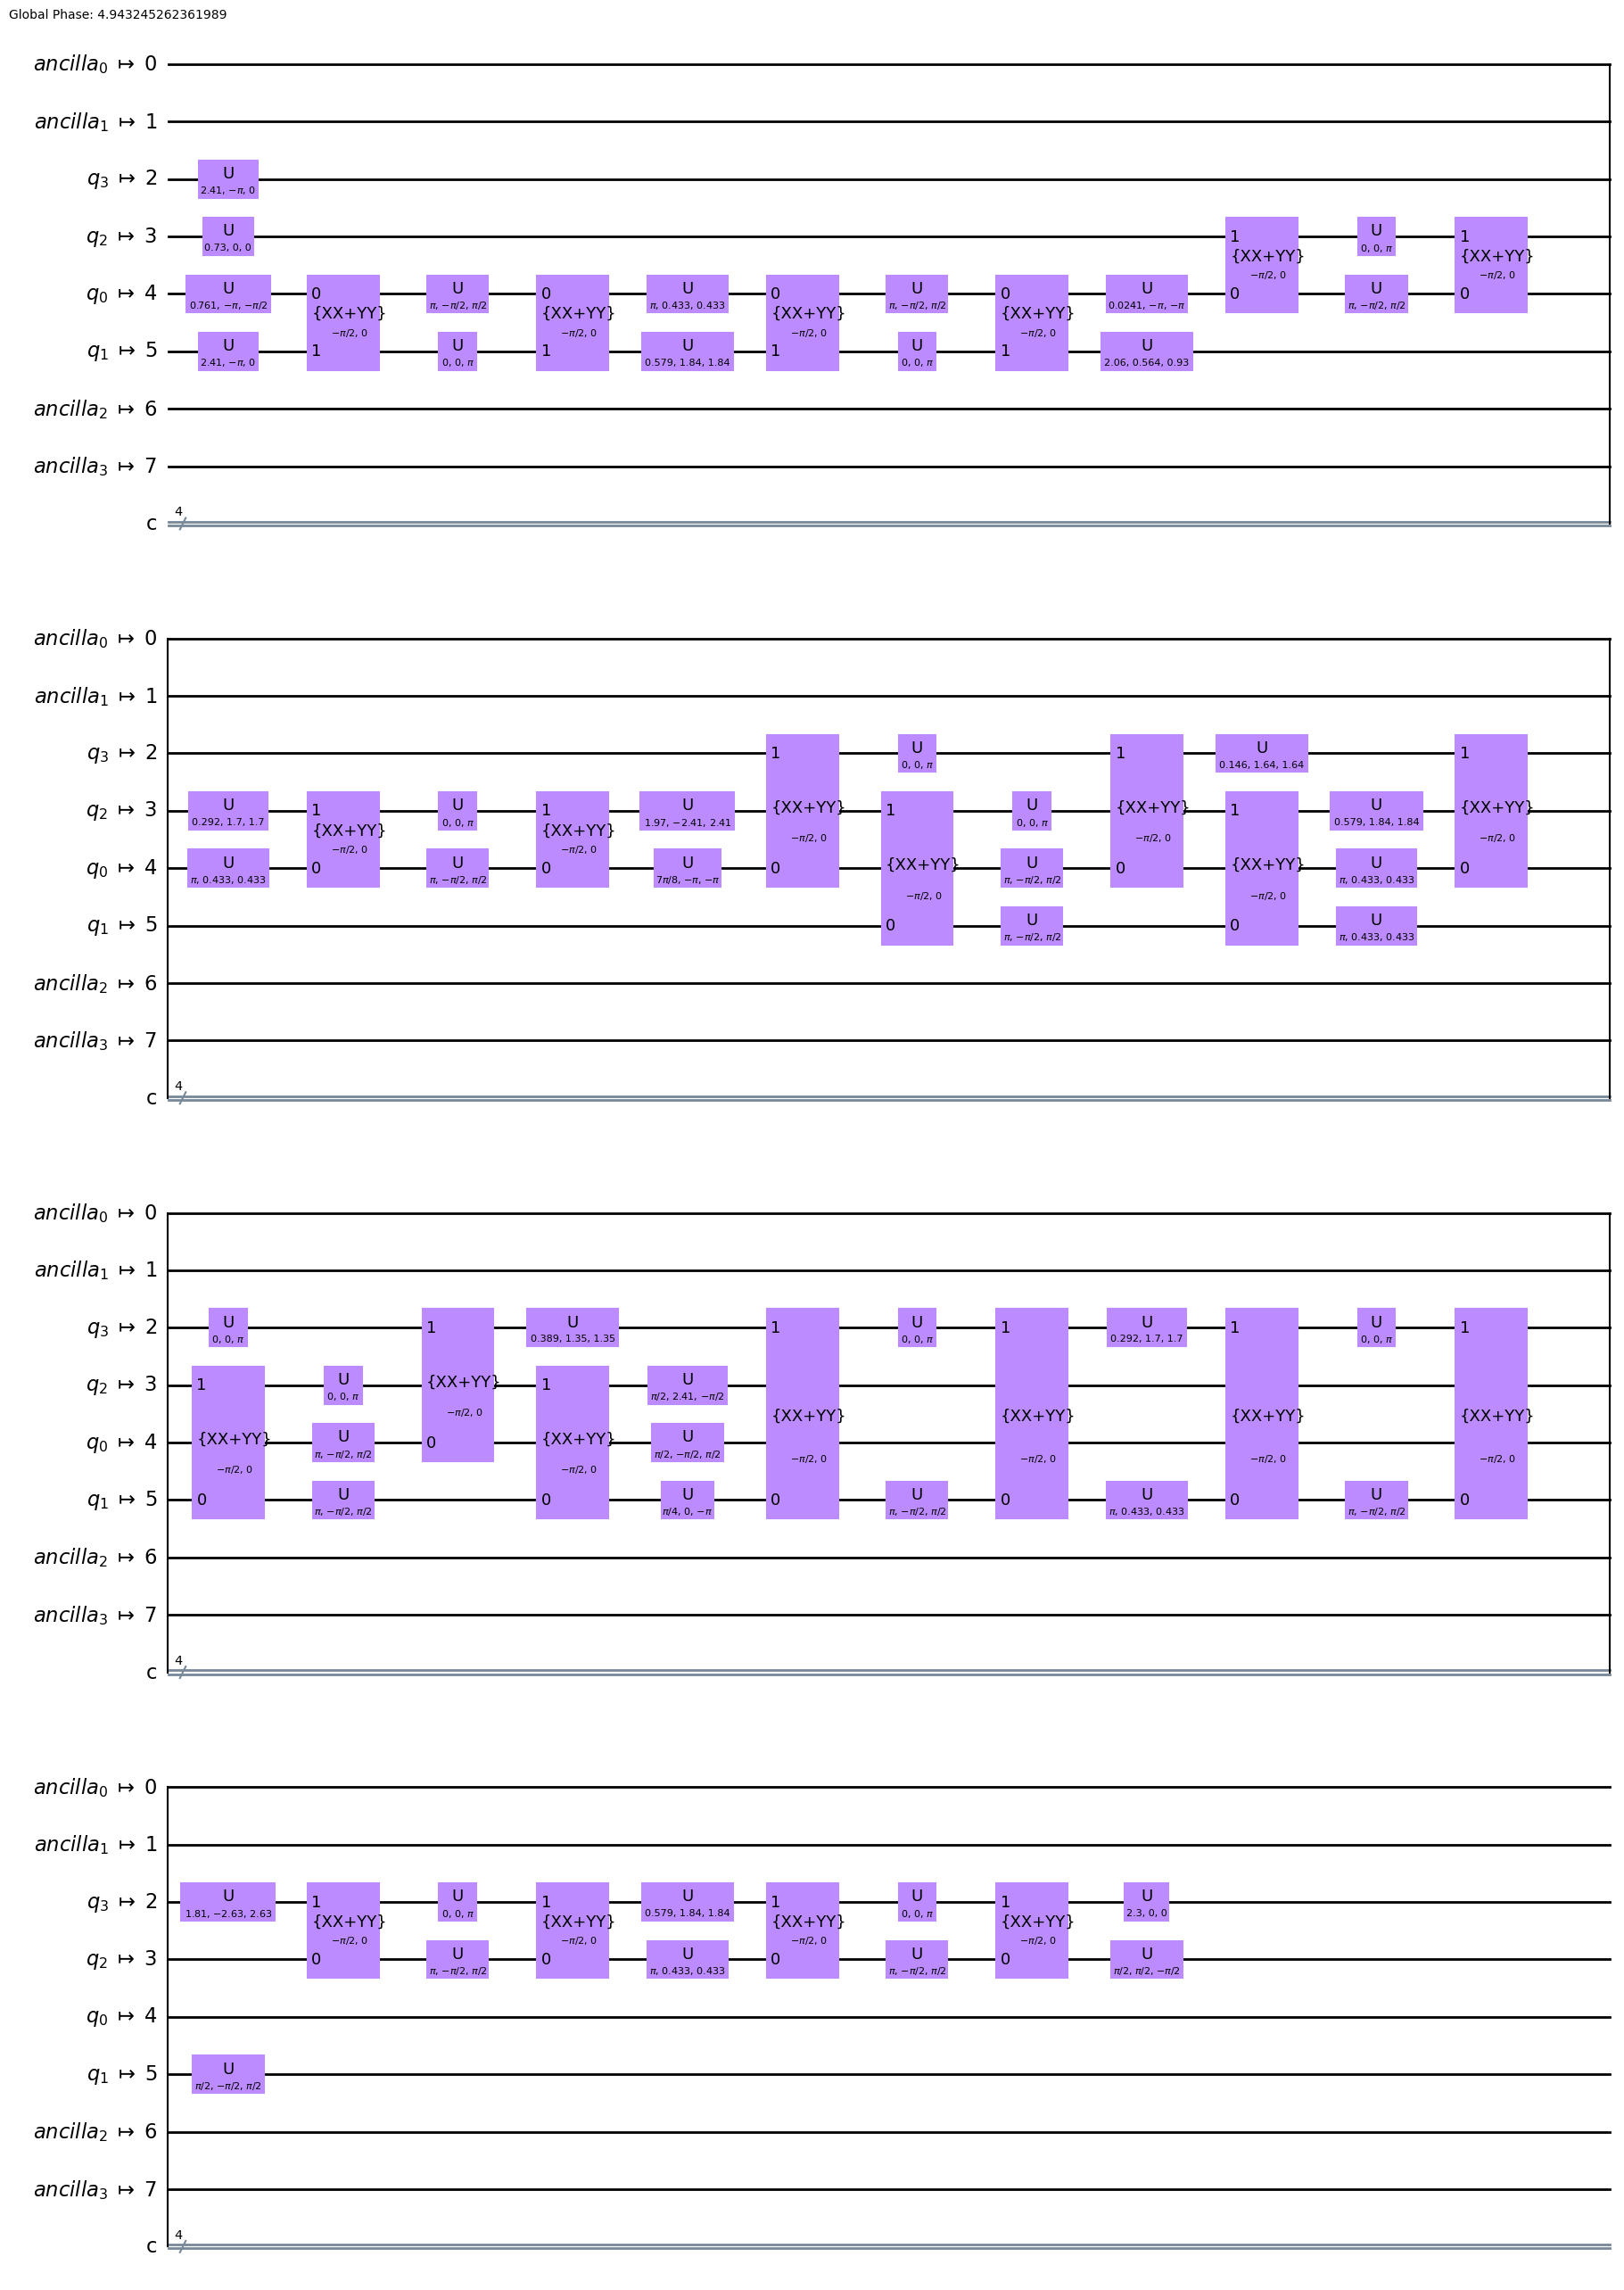

In [12]:
from qiskit import transpile

mirage_qc = transpile(
    qc,
    optimization_level=3,
    coupling_map=coupling_map,
    basis_gates=["u", "xx_plus_yy", "id"],
    routing_method="mirage",
    layout_method="sabre_layout_v2",
)
mirage_qc.draw(output="mpl")

8.5
2


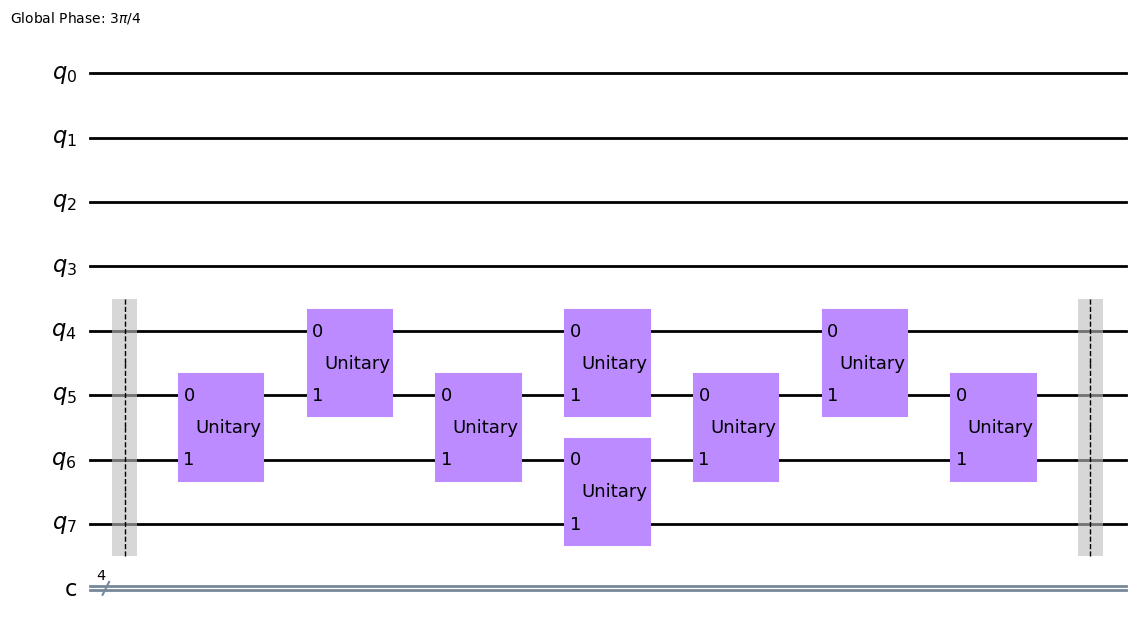

In [7]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
metric = DepthMetric(consolidate=False)
runner._append_metric_pass(metric)
metric = TotalSwaps(consolidate=False)
runner._append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["monodromy_depth"])
print(runner.property_set["total_swaps"])
# print(runner.property_set["monodromy_total"])
display(transp.draw(output="mpl", fold=-1))
# display(runner.property_set["post0"].draw("mpl"))